In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import IPython
import time
import IPython.display as display
from PIL import Image
import cv2

## Data Preparation

In [2]:
def imagePreprocess(imgUrl = './images/cow_shape.png', basewidth = 125, basic_image_shape = 300):
    out = np.array(Image.open(imgUrl))[:,:,0]
    out[out > 200] = 1000
    out[out <= 200] = 255
    out[out == 1000] = 0
    out[out < 255] = 0
    
    if basewidth >= 100:
        wpercent = (out.shape[0]/out.shape[1])
        hsize = int((float(basewidth)*float(wpercent)))
        out = cv2.resize(out, dsize=(basewidth, hsize))
    
    basic_image = np.zeros((basic_image_shape, basic_image_shape))
    basic_image[int((basic_image_shape/2)-(out.shape[0]/2)):int((basic_image_shape/2)+(out.shape[0]/2)), int((basic_image_shape/2)-(out.shape[1]/2)):int((basic_image_shape/2)+(out.shape[1]/2))] = out
    basic_image = basic_image/255
    
    return basic_image

In [3]:
cow = imagePreprocess('./images/cow_shape.png')
cat = imagePreprocess('./images/cat_shape.png')

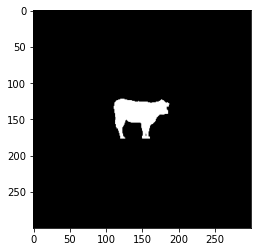

In [4]:
plt.imshow(cow,cmap='gray')

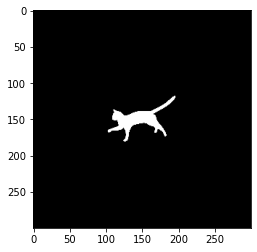

In [5]:
plt.imshow(cat,cmap='gray')

In [6]:
biased_train_cat = []
biased_train_cow = []

for i in range(1000):
  
  x_val = np.random.randint(46,60)
  y_val = np.random.randint(39,70)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cat, translation_matrix, (cat.shape[0], cat.shape[0]))
  biased_train_cat.append(im)
  x_val = np.random.randint(-53,-39)
  y_val = np.random.randint(-65,-34)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cat, translation_matrix, (cat.shape[0], cat.shape[0]))
  biased_train_cat.append(im)

  y_val = np.random.randint(44,64)
  x_val = np.random.randint(-46,-22)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cow, translation_matrix, (cat.shape[0], cat.shape[0]))
  biased_train_cow.append(im)
  y_val = np.random.randint(-56,-33)
  x_val = np.random.randint(55,78)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cow, translation_matrix, (cat.shape[0], cat.shape[0]))
  biased_train_cow.append(im)

unbiased_train_cat = []
unbiased_train_cow = []

for i in range(2000):
  
  x_val = np.random.randint(-53,60)
  y_val = np.random.randint(-65,70)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cat, translation_matrix, (cat.shape[0], cat.shape[0]))
  unbiased_train_cat.append(im)
  
  y_val = np.random.randint(-56,64)
  x_val = np.random.randint(-46,78)
  translation_matrix = np.float32([ [1,0,x_val], [0,1,y_val] ])
  im = cv2.warpAffine(cow, translation_matrix, (cat.shape[0], cat.shape[0]))
  unbiased_train_cow.append(im)
  
biased_train_cow = np.array(biased_train_cow)
biased_train_cat = np.array(biased_train_cat)
unbiased_train_cow = np.array(unbiased_train_cow)
unbiased_train_cat = np.array(unbiased_train_cat)

## Bundle train and test data

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time
from sklearn.model_selection import train_test_split

In [8]:
# cats are 0 and cows are 1
# generate test data
X_unbiased = np.concatenate((unbiased_train_cat, unbiased_train_cow))
X_unbiased = X_unbiased.reshape(X_unbiased.shape[0], X_unbiased.shape[1], X_unbiased.shape[2], 1)

y = np.concatenate((np.zeros(len(unbiased_train_cat)),np.ones(len(unbiased_train_cow))))
y = y.reshape(len(y), 1)

# generate train data
X_biased = np.concatenate((biased_train_cat,biased_train_cow))
X_biased = X_biased.reshape(X_biased.shape[0], X_biased.shape[1], X_biased.shape[2], 1)

# split up biased data into train and i.i.d. test data
X_biased_train, X_biased_test, y_biased_train, y_biased_test = train_test_split(X_biased, y, test_size=0.25, random_state=1)
X_unbiased_train, X_unbiased_test, y_unbiased_train, y_unbiased_test = train_test_split(X_unbiased, y, test_size=0.25, random_state=1)
test_unbiased = tf.data.Dataset.from_tensor_slices((X_unbiased, y))
training_biased = tf.data.Dataset.from_tensor_slices((X_biased_train, y_biased_train))
test_biased = tf.data.Dataset.from_tensor_slices((X_biased_test, y_biased_test))
training_unbiased = tf.data.Dataset.from_tensor_slices((X_unbiased_train, y_unbiased_train))

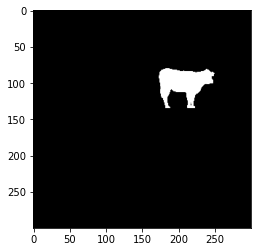

In [13]:
plt.imshow(X_biased[3001], cmap='gray')

### Visualize biased data

In [16]:
def visualize_samples(data):
  class_types = ["cat", "cow"]
  check_list = list(data.as_numpy_iterator())

  fig = plt.figure(figsize=(8,8))
  for i in range(25, 50):
    plt.subplot(5,5,(i-25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(check_list[i][0], cmap='gray')
    plt.xlabel(class_types [int(check_list[i][1][0])], fontsize=13)
  plt.tight_layout()
  plt.show()

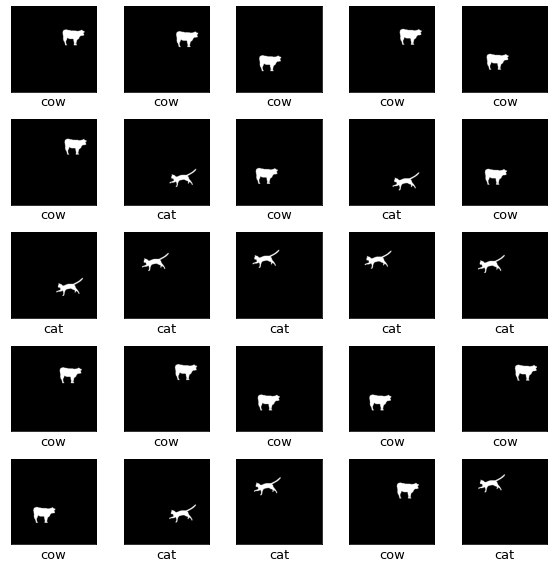

In [17]:
visualize_samples(training_biased)

### Visualize unbiased data

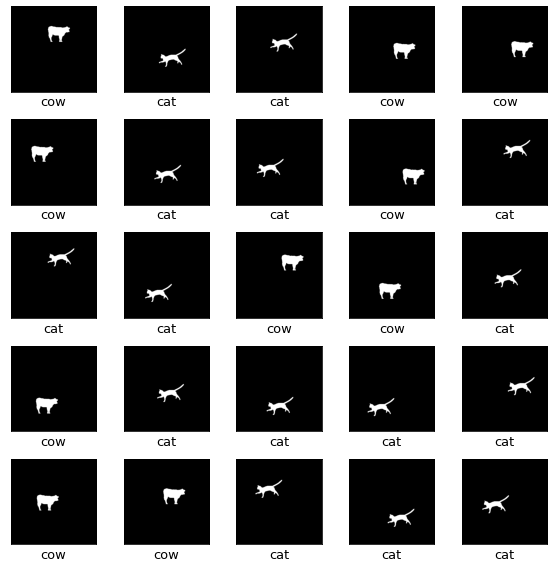

In [11]:
visualize_samples(test_unbiased.shuffle(buffer_size=len(y)))

### Data Augmentation

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

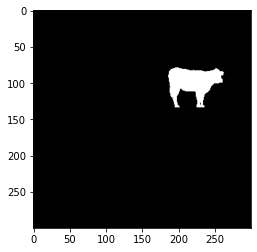

In [13]:
plt.imshow(X_biased_train[0], cmap="gray")

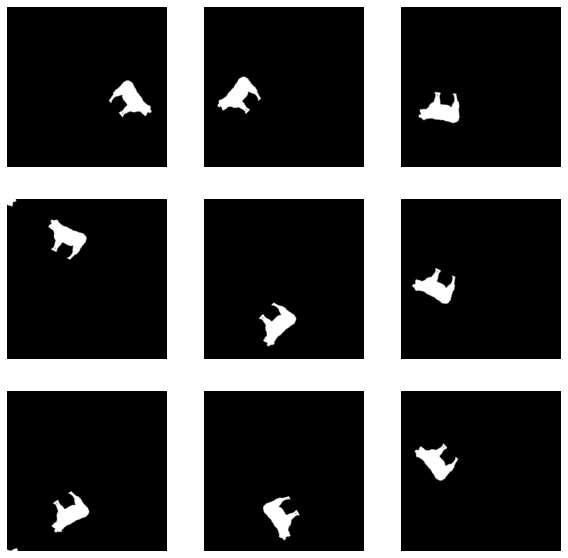

In [14]:
for image, _ in training_biased.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0], cmap="gray")
        plt.axis('off')

## Build an ANN net with tensorflow

### Train fully connected ANN with 4 hidden layers and one output layer

In [15]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout

In [16]:
def dnn_model(data = training_biased, 
            fit = False, regularization = False,
            load = True, epochs = 5, augmentation = False):
    
    data = data.shuffle(buffer_size=40000).batch(128).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    # define callback options
    dnn_checkpoint_path = "dnn_checkpoints/dnn"
    if regularization:
        dnn_checkpoint_path = dnn_checkpoint_path + "_reg"
    if augmentation:
        dnn_checkpoint_path = dnn_checkpoint_path + "_aug"
    dnn_checkpoint_path = dnn_checkpoint_path + ".ckpt"

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=dnn_checkpoint_path,
                                                    save_weights_only=True,
                                                    verbose=1)

    # define model
    if augmentation:
        dnn = Sequential([data_augmentation])
    else:
        dnn = Sequential()
    dnn.add(Flatten())
    dnn.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
    if regularization:
        dnn.add(Dropout(0.2))
    dnn.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
    if regularization:
        dnn.add(Dropout(0.2))
    dnn.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
    if regularization:
        dnn.add(Dropout(0.2))
    dnn.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
    if regularization:
        dnn.add(Dropout(0.2))
    dnn.add(Dense(1, activation='sigmoid'))
    # # compile the model
    opt = keras.optimizers.Adam(learning_rate=0.001)
    dnn.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    # # fit the model
    if fit:
        dnn.fit(data,
            epochs=epochs,
            callbacks=[cp_callback])
    if load:
        dnn.load_weights(dnn_checkpoint_path)
    
    return dnn

#### Not augmented data

In [37]:
print("### Training normal DNN ###")
dnn = dnn_model()
print("### Training normal DNN with dropout ###")
dnn_dropout = dnn_model(regularization=True)

### Training normal DNN ###
### Training normal DNN with dropout ###


#### Augmented Data

In [28]:
print("### Training normal DNN with augmentation ###")
dnn_aug = dnn_model(epochs = 20, augmentation = True)
print("### Training normal DNN with dropout and augmentation ###")
dnn_dropout_aug = dnn_model(regularization=True, epochs = 20, augmentation = True)

### Training normal DNN with augmentation ###
### Training normal DNN with dropout and augmentation ###


In [69]:
print("### Training normal DNN with dropout and augmentation ###")
dnn_unbiased_dropout_aug = dnn_model(data = training_unbiased, regularization=True, epochs = 50, augmentation = True)

### Training normal DNN with dropout and augmentation ###


### Evaluation

#### No Augmentatioin

In [66]:
def model_evaluation(X_test = X_biased_test, y_test = y_biased_test, biased = True, model = dnn):
    if biased:
        loss, acc = model.evaluate(X_test, y_test)
        print('Test Accuracy on biased i.i.d. test data: %.3f' % acc)
    else:
        loss, acc = model.evaluate(X_unbiased, y)
        print('Test Accuracy on unbiased o.o.d. test data: %.3f' % acc)


In [39]:
print("### without dropout ###")
model_evaluation(model = dnn)
model_evaluation(model = dnn, biased = False)
print("### with dropout")
model_evaluation(model = dnn_dropout)
model_evaluation(model = dnn_dropout, biased = False)

### without dropout ###
32/32 [==============================] - 1s 20ms/step - loss: 1.0638e-07 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 3s 22ms/step - loss: 9.3940 - accuracy: 0.4860
Test Accuracy on unbiased o.o.d. test data: 0.486
### with dropout
32/32 [==============================] - 1s 21ms/step - loss: 6.8388e-38 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 3s 21ms/step - loss: 26.2542 - accuracy: 0.4782
Test Accuracy on unbiased o.o.d. test data: 0.478


**Perfect result: Based on a normal train/test split we achieve a perfect accuracy-score** <br/>
**Based on o.o.d. test data the model performs similar to random guessing**

#### Augmentation

In [40]:
print("### without dropout ###")
model_evaluation(model = dnn_aug)
model_evaluation(model = dnn_aug, biased = False)
print("### with dropout")
model_evaluation(model = dnn_dropout_aug)
model_evaluation(model = dnn_dropout_aug, biased = False)

### without dropout ###
32/32 [==============================] - 1s 23ms/step - loss: 1.2314e-04 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 3s 24ms/step - loss: 3.2457 - accuracy: 0.6355
Test Accuracy on unbiased o.o.d. test data: 0.636
### with dropout
32/32 [==============================] - 1s 25ms/step - loss: 5.3144e-04 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 3s 25ms/step - loss: 3.8409 - accuracy: 0.6240
Test Accuracy on unbiased o.o.d. test data: 0.624


In [70]:
print("### with dropout on unbiased")
model_evaluation(X_test = X_unbiased_test, y_test = y_unbiased_test, model = dnn_unbiased_dropout_aug, biased = False)

### with dropout on unbiased
125/125 [==============================] - 4s 24ms/step - loss: 0.0134 - accuracy: 0.9958
Test Accuracy on unbiased o.o.d. test data: 0.996


## Build 1 block VGG in tensorflow

### Define architectures

In [41]:
def vgg_x(data = training_biased, 
		blocks = 1, fit = False, load = True,
		epochs = 5, regularization = False, 
		augmentation = False):
	
	data = data.shuffle(buffer_size=40000).batch(128).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
	# Create a callback that saves the model's weights
	vggx_checkpoint_path = "dnn_checkpoints/dnn"
	if regularization:
		vggx_checkpoint_path = vggx_checkpoint_path + "_reg"
	if augmentation:
		vggx_checkpoint_path = vggx_checkpoint_path + "_aug"
	vggx_checkpoint_path = vggx_checkpoint_path + ".ckpt"
	
	cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=vggx_checkpoint_path,
													save_weights_only=True,
													verbose=1)

	if augmentation:
		vgg = Sequential([data_augmentation])
	else:
		vgg = Sequential()
	
	vgg.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(300, 300, 1)))
	vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

	if regularization:
		print("### Dropout 1 ###")
		vgg.add(Dropout(0.2))

	if blocks > 1:
		print("### ConvBlock 2 ###")
		vgg.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
		vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

		if regularization:
			print("### Dropout 2 ###")
			vgg.add(Dropout(0.2))
	
	if blocks > 2:
		print("### ConvBlock 3 ###")
		vgg.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
		vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
		
		if regularization:
			print("### Dropout 3 ###")
			vgg.add(Dropout(0.2))

	########## remains the same for all VGG architectures ##########
	vgg.add(Flatten())
	vgg.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))

	if regularization:
		print("### Dropout 4 ###")
		vgg.add(Dropout(0.5))
	
	vgg.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = tf.keras.optimizers.Adam(learning_rate=0.001)
	vgg.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

	if fit:
		vgg.fit(data, epochs=epochs, callbacks=[cp_callback])
	if load:
		vgg.load_weights(vggx_checkpoint_path)

	return vgg

### VGG1

In [26]:
vgg1 = vgg_x(blocks = 1, epochs = 2)
vgg1_dropout = vgg_x(blocks = 1, regularization = True, epochs = 2)

### Dropout 1 ###
### Dropout 4 ###


In [42]:
print("### without dropout ###")
model_evaluation(model = vgg1)
model_evaluation(model = vgg1, biased = False)
print("### with dropout")
model_evaluation(model = vgg1_dropout)
model_evaluation(model = vgg1_dropout, biased = False)

### without dropout ###
32/32 [==============================] - 3s 88ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 10s 83ms/step - loss: 91.2808 - accuracy: 0.4835
Test Accuracy on unbiased o.o.d. test data: 0.484
### with dropout
32/32 [==============================] - 3s 85ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 11s 86ms/step - loss: 88.1018 - accuracy: 0.4835
Test Accuracy on unbiased o.o.d. test data: 0.484


In [45]:
vgg1_aug = vgg_x(blocks = 1, augmentation = True, epochs = 12)
vgg1_dropout_aug = vgg_x(blocks = 1, regularization = True, augmentation = True, epochs = 12)

### Dropout 1 ###
### Dropout 4 ###


In [46]:
print("### without dropout ###")
model_evaluation(model = vgg1_aug)
model_evaluation(model = vgg1_aug, biased = False)
print("### with dropout")
model_evaluation(model = vgg1_dropout_aug)
model_evaluation(model = vgg1_dropout_aug, biased = False)

### without dropout ###
32/32 [==============================] - 4s 89ms/step - loss: 1.3033e-04 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 11s 89ms/step - loss: 5.1681 - accuracy: 0.7460
Test Accuracy on unbiased o.o.d. test data: 0.746
### with dropout
32/32 [==============================] - 4s 90ms/step - loss: 7.8920e-05 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 11s 90ms/step - loss: 2.8166 - accuracy: 0.7887
Test Accuracy on unbiased o.o.d. test data: 0.789


### VGG2

In [49]:
vgg2 = vgg_x(blocks = 2, epochs = 2)
vgg2_dropout = vgg_x(blocks = 2, regularization = True, epochs = 2)

### ConvBlock 2 ###
### Dropout 1 ###
### ConvBlock 2 ###
### Dropout 2 ###
### Dropout 4 ###


In [50]:
print("### without dropout ###")
model_evaluation(model = vgg2)
model_evaluation(model = vgg2, biased = False)
print("### with dropout")
model_evaluation(model = vgg2_dropout)
model_evaluation(model = vgg2_dropout, biased = False)

### without dropout ###
32/32 [==============================] - 5s 142ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 18s 143ms/step - loss: 117.4579 - accuracy: 0.4848
Test Accuracy on unbiased o.o.d. test data: 0.485
### with dropout
32/32 [==============================] - 5s 138ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 18s 143ms/step - loss: 56.2255 - accuracy: 0.4835
Test Accuracy on unbiased o.o.d. test data: 0.484


In [52]:
vgg2_aug = vgg_x(blocks = 2, augmentation = True, epochs = 12)
vgg2_dropout_aug = vgg_x(blocks = 2, regularization = True, augmentation = True, epochs = 12)

### ConvBlock 2 ###
### Dropout 1 ###
### ConvBlock 2 ###
### Dropout 2 ###
### Dropout 4 ###


In [53]:
print("### without dropout ###")
model_evaluation(model = vgg2_aug)
model_evaluation(model = vgg2_aug, biased = False)
print("### with dropout")
model_evaluation(model = vgg2_dropout_aug)
model_evaluation(model = vgg2_dropout_aug, biased = False)

### without dropout ###
32/32 [==============================] - 5s 139ms/step - loss: 2.3021e-05 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 18s 142ms/step - loss: 3.7441 - accuracy: 0.6960
Test Accuracy on unbiased o.o.d. test data: 0.696
### with dropout
32/32 [==============================] - 5s 138ms/step - loss: 2.7626e-04 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 18s 143ms/step - loss: 2.9169 - accuracy: 0.7398
Test Accuracy on unbiased o.o.d. test data: 0.740


### VGG3

In [56]:
vgg3 = vgg_x(blocks = 3, epochs = 2)
vgg3_dropout = vgg_x(blocks = 3, regularization = True, epochs = 2)

### ConvBlock 2 ###
### ConvBlock 3 ###
### Dropout 1 ###
### ConvBlock 2 ###
### Dropout 2 ###
### ConvBlock 3 ###
### Dropout 3 ###
### Dropout 4 ###


In [57]:
print("### without dropout ###")
model_evaluation(model = vgg3)
model_evaluation(model = vgg3, biased = False)
print("### with dropout")
model_evaluation(model = vgg3_dropout)
model_evaluation(model = vgg3_dropout, biased = False)

### without dropout ###
32/32 [==============================] - 7s 206ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 26s 205ms/step - loss: 133.4791 - accuracy: 0.4863
Test Accuracy on unbiased o.o.d. test data: 0.486
### with dropout
32/32 [==============================] - 7s 204ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 26s 206ms/step - loss: 43.5443 - accuracy: 0.4860
Test Accuracy on unbiased o.o.d. test data: 0.486


In [61]:
vgg3_aug = vgg_x(blocks = 3, augmentation = True, epochs = 20)
vgg3_dropout_aug = vgg_x(blocks = 3, regularization = True, augmentation = True, epochs = 20)

### ConvBlock 2 ###
### ConvBlock 3 ###
### Dropout 1 ###
### ConvBlock 2 ###
### Dropout 2 ###
### ConvBlock 3 ###
### Dropout 3 ###
### Dropout 4 ###


In [62]:
print("### without dropout ###")
model_evaluation(model = vgg3_aug)
model_evaluation(model = vgg3_aug, biased = False)
print("### with dropout")
model_evaluation(model = vgg3_dropout_aug)
model_evaluation(model = vgg3_dropout_aug, biased = False)

### without dropout ###
32/32 [==============================] - 6s 189ms/step - loss: 9.8901e-06 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 26s 207ms/step - loss: 7.6764 - accuracy: 0.5882
Test Accuracy on unbiased o.o.d. test data: 0.588
### with dropout
32/32 [==============================] - 7s 199ms/step - loss: 1.5830e-05 - accuracy: 1.0000
Test Accuracy on biased i.i.d. test data: 1.000
125/125 [==============================] - 28s 220ms/step - loss: 5.0460 - accuracy: 0.6363
Test Accuracy on unbiased o.o.d. test data: 0.636
